[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Data berhasil disimpan ke dataset/data_bersih_sentimen.csv
Akurasi: 0.8579881656804734
Confusion Matrix:
 [[134   0]
 [ 24  11]]
Classification Report:
               precision    recall  f1-score   support

     negatif       0.85      1.00      0.92       134
     positif       1.00      0.31      0.48        35

    accuracy                           0.86       169
   macro avg       0.92      0.66      0.70       169
weighted avg       0.88      0.86      0.83       169



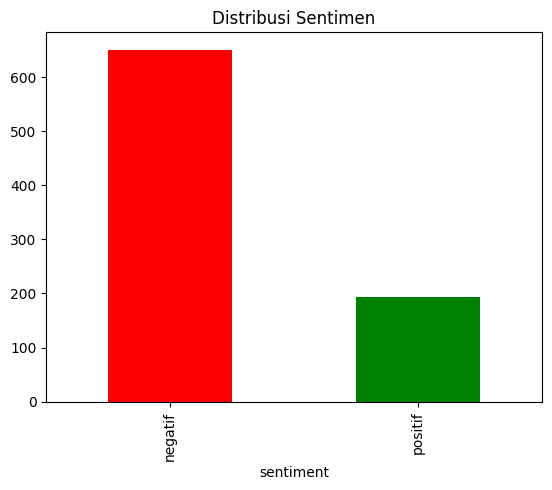

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

nltk.download('stopwords')

# === 1. Load dan filter data ===
df = pd.read_csv('dataset/ikn.csv')
keywords = ['ikn', 'nusantara', 'ibu kota', 'ibukota', 'pemindahan', 'perpindahan']
filtered_df = df[df['full_text'].str.contains('|'.join(keywords), case=False)].copy()

filtered_df = filtered_df[filtered_df['full_text'].str.strip() != '']
filtered_df = filtered_df.drop_duplicates(subset='full_text')
filtered_df['full_text'] = filtered_df['full_text'].str.replace(r'http\S+', '', regex=True)
filtered_df['word_count'] = filtered_df['full_text'].apply(lambda x: len(x.split()))
filtered_df = filtered_df[filtered_df['word_count'] >= 5]
filtered_df.drop(columns=['word_count'], inplace=True)

# === 2. Preprocessing ===
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))
tambahan_stop = {
    'gw', 'gue', 'gua', 'lu', 'loe', 'lo', 'elu', 'nya', 'ya', 'aja', 'sih', 'lah', 'deh', 'dong',
    'kok', 'nih', 'tuh', 'lagi', 'kayak', 'gak', 'ga', 'nggak', 'ngga', 'yg', 'yang', 'saya', 'kamu'
}
stop_words.update(tambahan_stop)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = re.sub(r'\bgw\b|\bgue\b|\bgua\b', 'saya', text)
    text = re.sub(r'\blu\b|\bloe\b|\belo\b|\belu\b', 'kamu', text)
    text = re.sub(r'\bnggak\b|\bngga\b|\bga\b|\bgak\b', 'tidak', text)
    text = stemmer.stem(text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

filtered_df['cleaned'] = filtered_df['full_text'].apply(clean_text)

# === 2.1 Perkaya dan Gabungkan Kamus Kata Dasar ===
with open('sastrawi/kata-dasar.txt', 'r', encoding='utf-8') as f:
    kamus_sastrawi = set(f.read().splitlines())

pos_words = [
    'baik', 'bagus', 'mendukung', 'hebat', 'mantap', 'setuju',
    'top', 'luar biasa', 'sip', 'apresiasi', 'bangga',
    'kemajuan', 'ramah', 'berkelanjutan', 'peluang', 'strategis',
    'pertumbuhan', 'investasi', 'unggulan', 'mendorong', 'semangat',
    'kondusif', 'cocok', 'positif', 'cerah', 'maju', 'bermanfaat',
    'berkembang', 'terdepan', 'mendorong', 'sukses', 'membangun'
]
neg_words = [
    'buruk', 'jelek', 'korupsi', 'parah', 'gagal', 'tolak',
    'tidak setuju', 'menolak', 'ancur', 'bubar', 'kritik', 'macet',
    'tidak ramah', 'tidak layak', 'tidak manusiawi', 'tidak cocok',
    'bohong', 'salah', 'mundur', 'krisis', 'masalah', 'keluhan',
    'cacat', 'curang', 'konflik', 'resah'
]

pos_words_stemmed = [stemmer.stem(w.lower()) for w in pos_words]
neg_words_stemmed = [stemmer.stem(w.lower()) for w in neg_words]

kamus_kata = kamus_sastrawi.union(set(pos_words_stemmed)).union(set(neg_words_stemmed))

def hapus_kata_non_kamus(text):
    filtered_words = [word for word in text.split() if word in kamus_kata]
    if len(filtered_words) == 0:
        return text
    else:
        return ' '.join(filtered_words)

filtered_df['final_cleaned'] = filtered_df['cleaned'].apply(hapus_kata_non_kamus)

# === 3. Sentiment label dari fungsi simple_sentiment ===
def simple_sentiment(text):
    score = 0
    for word in text.split():
        if word in pos_words_stemmed:
            score += 1
        elif word in neg_words_stemmed:
            score -= 1
    return 'positif' if score > 0 else 'negatif'

filtered_df['sentiment'] = filtered_df['final_cleaned'].apply(simple_sentiment)

# === 4. Simpan data bersih ===
filtered_df[['full_text', 'final_cleaned', 'sentiment']].to_csv('dataset/data_bersih_sentimen.csv', index=False)
print("✅ Data berhasil disimpan ke dataset/data_bersih_sentimen.csv")

# === 5. Label encoding ===
le = LabelEncoder()
filtered_df['label'] = le.fit_transform(filtered_df['sentiment'])

# === 6. TF-IDF + Naive Bayes ===
tfidf = TfidfVectorizer(max_features=5000)

X = filtered_df['final_cleaned']
y = filtered_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# === 7. Evaluasi model ===
y_pred = model.predict(X_test_tfidf)

print("Akurasi:", accuracy_score(y_test, y_pred))

labels = le.transform(['negatif', 'positif'])

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=labels))
print("Classification Report:\n", classification_report(y_test, y_pred, labels=labels, target_names=['negatif', 'positif'], zero_division=1))

# === 8. Visualisasi distribusi sentimen ===
filtered_df['sentiment'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribusi Sentimen')
plt.show()


In [2]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sqlalchemy import create_engine
from sqlalchemy import text
import json

# Download stopwords jika belum tersedia
nltk.download('stopwords')

# Koneksi ke MySQL via SQLAlchemy
engine = create_engine("mysql+mysqlconnector://root:@localhost/ikn-app")

# Load dataset CSV
df = pd.read_csv('dataset/ikn.csv')

# Simpan ke tabel 'dataset'
df.to_sql(name='dataset', con=engine, if_exists='replace', index=False)

# Filter hanya data dengan kata kunci
keywords = ['ikn', 'nusantara', 'ibu kota', 'ibukota', 'pemindahan', 'perpindahan']
filtered_df = df[df['full_text'].str.contains('|'.join(keywords), case=False, na=False)].copy()
filtered_df = filtered_df[filtered_df['full_text'].str.strip() != '']
filtered_df = filtered_df.drop_duplicates(subset='full_text')

# Inisialisasi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Load kamus kata dasar
kamus_path = 'sastrawi/kata-dasar.txt'
with open(kamus_path, 'r', encoding='utf-8') as f:
    kamus_sastrawi = set(word.strip() for word in f.readlines())

# Kata penting
kata_penting = {'ikn', 'nusantara', 'ibu', 'kota', 'ibukota', 'pemindahan', 'perpindahan'}

# Stopwords
stop_words = set(stopwords.words('indonesian'))
tambahan_stop = {
    'gw', 'gue', 'gua', 'lu', 'loe', 'lo', 'elu', 'nya', 'ya', 'aja', 'sih', 'lah', 'deh', 'dong',
    'kok', 'nih', 'tuh', 'lagi', 'kayak', 'gak', 'ga', 'nggak', 'ngga', 'yg', 'yang', 'saya', 'kamu'
}
stop_words.update(tambahan_stop)

# Kata sentimen
kata_positif = {'baik', 'bagus', 'maju', 'dukung', 'setuju', 'positif', 'indah', 'hebat'}
kata_negatif = {'tidak', 'buruk', 'tolak', 'negatif', 'korup', 'jelek', 'hancur', 'bencana', 'rusak'}

# Fungsi preprocessing
def preprocess_steps(text):
    # Bersihkan teks (hapus url, hashtag, mention, angka)
    data_clean = re.sub(r'http\S+|#\w+|@\w+|\d+', '', text)
    lower = data_clean.lower()
    no_punct = lower.translate(str.maketrans('', '', string.punctuation))
    replaced = re.sub(r'\bgw\b|\bgue\b|\bgua\b', 'saya', no_punct)
    replaced = re.sub(r'\blu\b|\bloe\b|\belo\b|\belu\b', 'kamu', replaced)
    replaced = re.sub(r'\bnggak\b|\bngga\b|\bga\b|\bgak\b', 'tidak', replaced)

    tokens = replaced.split()

    # Hapus stopword
    tokens_stop_removed = [w for w in tokens if w not in stop_words]

    # Gabungkan untuk stemming
    joined_for_stem = ' '.join(tokens_stop_removed)
    stemmed_text = stemmer.stem(joined_for_stem)

    # Token hasil stemming
    stemmed_tokens = stemmed_text.split()

    # Filtering: hanya kata di kamus atau penting
    tokens_filtered = [w for w in stemmed_tokens if w in kamus_sastrawi or w in kata_penting]

    # Urutkan
    tokens_sorted = sorted(tokens_filtered)

    # Gabungkan hasil akhir
    final_cleaned = ' '.join(tokens_sorted)

    # Deteksi sentimen
    sentimen = 'positif' if any(k in tokens_sorted for k in kata_positif) else (
        'negatif' if any(k in tokens_sorted for k in kata_negatif) else 'negatif'
    )

    return pd.Series([
        final_cleaned,
        lower,
        no_punct,
        json.dumps(tokens, ensure_ascii=False),
        json.dumps(tokens_stop_removed, ensure_ascii=False),
        json.dumps(tokens_sorted, ensure_ascii=False),
        sentimen
    ])

# Terapkan preprocessing
processed = filtered_df['full_text'].apply(preprocess_steps)
processed.columns = [
    'data_clean',
    'lowercasing',
    'remove_punctuation',
    'tokenizing',
    'stopword',
    'stemming',
    'sentimen'
]

# Filter hasil akhir: hanya yang terdiri dari >= 3 kata
processed['jumlah_kata'] = processed['data_clean'].str.split().str.len()
processed = processed[processed['jumlah_kata'] >= 3].drop(columns=['jumlah_kata'])

# Tambahkan kolom id sebagai primary key
processed.reset_index(drop=True, inplace=True)
processed.insert(0, 'id', processed.index + 1)

# Simpan ke MySQL
processed.to_sql(name='preprocessing', con=engine, if_exists='replace', index=False)

# Jadikan id sebagai PRIMARY KEY dan AUTO_INCREMENT
with engine.connect() as conn:
    conn.execute(text("""
        ALTER TABLE preprocessing
        MODIFY COLUMN id INT NOT NULL AUTO_INCREMENT,
        ADD PRIMARY KEY (id);
    """))

# Tampilkan hasil
print("✅ Data berhasil disimpan ke tabel MySQL: 'dataset', 'preprocessing'")
print("📌 Contoh data hasil pembersihan dan sentimen:")
print(processed[['id', 'stemming', 'sentimen']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Data berhasil disimpan ke tabel MySQL: 'dataset', 'preprocessing'
📌 Contoh data hasil pembersihan dan sentimen:
   id                                           stemming sentimen
0   1  ["baca", "baca", "dalam", "ikn", "ilustrasi", ...  negatif
1   2  ["cabang", "dinasti", "dinasti", "dukung", "du...  positif
2   3  ["cermin", "identitas", "ikn", "indonesia", "k...  positif
3   4  ["bas", "ikn", "kota", "lanjut", "lingkung", "...  negatif
4   5  ["bahan", "bangun", "hidup", "ikn", "jasa", "j...  negatif


In [3]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import json

# Unduh stopwords jika belum
nltk.download('stopwords')

# Load CSV
df = pd.read_csv('dataset/ikn.csv')

# Filter hanya data relevan
keywords = ['ikn', 'nusantara', 'ibu kota', 'ibukota', 'pemindahan', 'perpindahan']
filtered_df = df[df['full_text'].str.contains('|'.join(keywords), case=False, na=False)].copy()
filtered_df = filtered_df[filtered_df['full_text'].str.strip() != '']
filtered_df = filtered_df.drop_duplicates(subset='full_text')

# Inisialisasi Stemmer
stemmer = StemmerFactory().create_stemmer()

# Muat kamus kata dasar
with open('sastrawi/kata-dasar.txt', 'r', encoding='utf-8') as f:
    kamus_sastrawi = set(word.strip() for word in f.readlines())

# Kata penting
kata_penting = {'ikn', 'nusantara', 'ibu', 'kota', 'ibukota', 'pemindahan', 'perpindahan'}

# Stopwords
stop_words = set(stopwords.words('indonesian'))
tambahan_stop = {
    'gw', 'gue', 'gua', 'lu', 'loe', 'lo', 'elu', 'nya', 'ya', 'aja', 'sih', 'lah', 'deh', 'dong',
    'kok', 'nih', 'tuh', 'lagi', 'kayak', 'gak', 'ga', 'nggak', 'ngga', 'yg', 'yang', 'saya', 'kamu'
}
stop_words.update(tambahan_stop)

# Kata sentimen
kata_positif = {'baik', 'bagus', 'maju', 'dukung', 'setuju', 'positif', 'indah', 'hebat'}
kata_negatif = {'tidak', 'buruk', 'tolak', 'negatif', 'korup', 'jelek', 'hancur', 'bencana', 'rusak'}

# Fungsi preprocessing
def preprocess_steps(text):
    # Cleaning
    data_clean = re.sub(r'http\S+|#\w+|@\w+|\d+', '', text)
    lower = data_clean.lower()
    no_punct = lower.translate(str.maketrans('', '', string.punctuation))
    replaced = re.sub(r'\bgw\b|\bgue\b|\bgua\b', 'saya', no_punct)
    replaced = re.sub(r'\blu\b|\bloe\b|\belo\b|\belu\b', 'kamu', replaced)
    replaced = re.sub(r'\bnggak\b|\bngga\b|\bga\b|\bgak\b', 'tidak', replaced)

    tokens = replaced.split()

    # Stopword removal
    tokens_stop_removed = [w for w in tokens if w not in stop_words]

    # Stemming
    joined_for_stem = ' '.join(tokens_stop_removed)
    stemmed_text = stemmer.stem(joined_for_stem)

    stemmed_tokens = stemmed_text.split()

    # Filter kata dasar atau penting
    tokens_filtered = [w for w in stemmed_tokens if w in kamus_sastrawi or w in kata_penting]
    tokens_sorted = sorted(tokens_filtered)
    final_cleaned = ' '.join(tokens_sorted)

    # Deteksi sentimen
    sentimen = 'positif' if any(k in tokens_sorted for k in kata_positif) else (
        'negatif' if any(k in tokens_sorted for k in kata_negatif) else 'negatif'
    )

    return pd.Series([final_cleaned, sentimen])

# Terapkan preprocessing
processed = filtered_df['full_text'].apply(preprocess_steps)
processed.columns = ['clean_text', 'sentimen']

# Hapus teks pendek
processed['jumlah_kata'] = processed['clean_text'].str.split().str.len()
processed = processed[processed['jumlah_kata'] >= 3].drop(columns='jumlah_kata')

# Tambahkan ID
processed.reset_index(drop=True, inplace=True)
processed.insert(0, 'id', processed.index + 1)

# Simpan hasil preprocessing ke CSV
processed.to_csv('dataset/processed.csv', index=False)

# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed['clean_text'])
y = processed['sentimen']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Evaluasi
cm = confusion_matrix(y_test, y_pred, labels=['positif', 'negatif'])
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Tampilkan hasil
print("✅ TF-IDF + Naive Bayes selesai.")
print(f"📌 Akurasi: {acc * 100:.2f}%")
print("\n📊 Confusion Matrix:")
print(pd.DataFrame(cm, index=['Actual_Pos', 'Actual_Neg'], columns=['Pred_Pos', 'Pred_Neg']))
print("\n📋 Classification Report:")
print(report)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ TF-IDF + Naive Bayes selesai.
📌 Akurasi: 88.66%

📊 Confusion Matrix:
            Pred_Pos  Pred_Neg
Actual_Pos         1        22
Actual_Neg         0       171

📋 Classification Report:
              precision    recall  f1-score   support

     negatif       0.89      1.00      0.94       171
     positif       1.00      0.04      0.08        23

    accuracy                           0.89       194
   macro avg       0.94      0.52      0.51       194
weighted avg       0.90      0.89      0.84       194



In [12]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
import numpy as np

# Unduh stopwords bahasa Indonesia (jika belum)
nltk.download('stopwords')

# Load dataset
df = pd.read_csv('dataset/ikn.csv')

# Filter berdasarkan kata kunci tertentu
keywords = ['ikn', 'nusantara', 'ibu kota', 'ibukota', 'pemindahan', 'perpindahan']
filtered_df = df[df['full_text'].str.contains('|'.join(keywords), case=False, na=False)].copy()
filtered_df = filtered_df[filtered_df['full_text'].str.strip() != '']
filtered_df = filtered_df.drop_duplicates(subset='full_text')

# Inisialisasi stemmer Sastrawi
stemmer = StemmerFactory().create_stemmer()

# Muat kamus kata dasar dari file
with open('sastrawi/kata-dasar.txt', 'r', encoding='utf-8') as f:
    kamus_sastrawi = set(word.strip() for word in f.readlines())

# Kata penting yang harus dipertahankan
kata_penting = {'ikn', 'nusantara', 'ibu', 'kota', 'ibukota', 'pemindahan', 'perpindahan'}

# Stopwords bahasa Indonesia + tambahan slang
stop_words = set(stopwords.words('indonesian'))
tambahan_stop = {
    'gw', 'gue', 'gua', 'lu', 'loe', 'lo', 'elu', 'nya', 'ya', 'aja', 'sih', 'lah', 'deh', 'dong',
    'kok', 'nih', 'tuh', 'lagi', 'kayak', 'gak', 'ga', 'nggak', 'ngga', 'yg', 'yang', 'saya', 'kamu'
}
stop_words.update(tambahan_stop)

# Kata yang berkonotasi positif dan negatif
kata_positif = {'baik', 'bagus', 'maju', 'dukung', 'setuju', 'positif', 'indah', 'hebat'}
kata_negatif = {'tidak', 'buruk', 'tolak', 'negatif', 'korup', 'jelek', 'hancur', 'bencana', 'rusak'}

def preprocess_steps(text):
    # Bersihkan teks dari url, tag, angka
    data_clean = re.sub(r'http\S+|#\w+|@\w+|\d+', '', text)
    lower = data_clean.lower()
    # Hilangkan tanda baca
    no_punct = lower.translate(str.maketrans('', '', string.punctuation))
    # Ganti kata slang
    replaced = re.sub(r'\bgw\b|\bgue\b|\bgua\b', 'saya', no_punct)
    replaced = re.sub(r'\blu\b|\bloe\b|\belo\b|\belu\b', 'kamu', replaced)
    replaced = re.sub(r'\bnggak\b|\bngga\b|\bga\b|\bgak\b', 'tidak', replaced)
    tokens = replaced.split()
    # Stopword removal
    tokens_stop_removed = [w for w in tokens if w not in stop_words]
    joined_for_stem = ' '.join(tokens_stop_removed)
    # Stemming
    stemmed_text = stemmer.stem(joined_for_stem)
    stemmed_tokens = stemmed_text.split()
    # Filter hanya kata dari kamus atau kata penting
    tokens_filtered = [w for w in stemmed_tokens if w in kamus_sastrawi or w in kata_penting]
    tokens_sorted = sorted(tokens_filtered)
    final_cleaned = ' '.join(tokens_sorted)
    # Label sentimen berdasarkan kemunculan kata positif atau negatif
    sentimen = 'positif' if any(k in tokens_sorted for k in kata_positif) else 'negatif'
    return pd.Series([final_cleaned, sentimen])

# Preprocessing seluruh data
processed = filtered_df['full_text'].apply(preprocess_steps)
processed.columns = ['clean_text', 'sentimen']

# Filter data dengan minimal 3 kata
processed['jumlah_kata'] = processed['clean_text'].str.split().str.len()
processed = processed[processed['jumlah_kata'] >= 3].drop(columns='jumlah_kata').reset_index(drop=True)
processed.insert(0, 'id', processed.index + 1)

# Tampilkan jumlah sentimen setelah preprocessing dan penentuan label
print("📌 Jumlah data dan distribusi sentimen setelah preprocessing:")
print(processed['sentimen'].value_counts())

# Simpan hasil preprocessing jika perlu
processed.to_csv('dataset/processed.csv', index=False)

# Split data latih dan uji (train 75% test 25%) dengan stratify agar distribusi label sama
X = processed['clean_text']
y = processed['sentimen']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Debug print data train
print(f"Total data latih: {len(X_train)}")
print(f"Distribusi label train: {Counter(y_train)}")

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih Multinomial Naive Bayes dengan alpha=1
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train_tfidf, y_train)

# Tampilkan probabilitas prior dari model sklearn
print("\n🔢 Probabilitas Prior (model sklearn):")
for label, prior_log in zip(nb.classes_, nb.class_log_prior_):
    print(f"P({label}) = {np.exp(prior_log):.6f}")

# Prediksi data test dan evaluasi
y_pred = nb.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Tampilkan confusion matrix dengan label yang jelas
cm = confusion_matrix(y_test, y_pred, labels=['positif', 'negatif'])
cm_df = pd.DataFrame(cm, index=['Aktual Positif', 'Aktual Negatif'], columns=['Prediksi Positif', 'Prediksi Negatif'])

print(f"\n✅ Akurasi: {acc * 100:.2f}%")
print("\n📋 Classification Report:")
print(report)

print("\n📊 Confusion Matrix:")
print(cm_df)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


📌 Jumlah data dan distribusi sentimen setelah preprocessing:
sentimen
negatif    695
positif     80
Name: count, dtype: int64
Total data latih: 581
Distribusi label train: Counter({'negatif': 521, 'positif': 60})

🔢 Probabilitas Prior (model sklearn):
P(negatif) = 0.896730
P(positif) = 0.103270

✅ Akurasi: 91.75%

📋 Classification Report:
              precision    recall  f1-score   support

     negatif       0.92      1.00      0.96       174
     positif       1.00      0.20      0.33        20

    accuracy                           0.92       194
   macro avg       0.96      0.60      0.64       194
weighted avg       0.92      0.92      0.89       194


📊 Confusion Matrix:
                Prediksi Positif  Prediksi Negatif
Aktual Positif                 4                16
Aktual Negatif                 0               174


In [5]:
import pandas as pd
import re
import string
import nltk
import json
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Unduh stopwords jika belum
nltk.download('stopwords')

# Load dataset
df = pd.read_csv('dataset/ikn.csv')

# Filter relevan
keywords = ['ikn', 'nusantara', 'ibu kota', 'ibukota', 'pemindahan', 'perpindahan']
filtered_df = df[df['full_text'].str.contains('|'.join(keywords), case=False, na=False)].copy()
filtered_df = filtered_df[filtered_df['full_text'].str.strip() != '']
filtered_df = filtered_df.drop_duplicates(subset='full_text')

# Inisialisasi stemmer dan kata dasar
stemmer = StemmerFactory().create_stemmer()
with open('sastrawi/kata-dasar.txt', 'r', encoding='utf-8') as f:
    kamus_sastrawi = set(word.strip() for word in f.readlines())

# Kata penting, stopwords, dan kata sentimen
kata_penting = {'ikn', 'nusantara', 'ibu', 'kota', 'ibukota', 'pemindahan', 'perpindahan'}
stop_words = set(stopwords.words('indonesian'))
tambahan_stop = {'gw', 'gue', 'gua', 'lu', 'loe', 'lo', 'elu', 'nya', 'ya', 'aja', 'sih', 'lah', 'deh', 'dong', 'kok', 'nih', 'tuh', 'lagi', 'kayak', 'gak', 'ga', 'nggak', 'ngga', 'yg', 'yang', 'saya', 'kamu'}
stop_words.update(tambahan_stop)
kata_positif = {'baik', 'bagus', 'maju', 'dukung', 'setuju', 'positif', 'indah', 'hebat'}
kata_negatif = {'tidak', 'buruk', 'tolak', 'negatif', 'korup', 'jelek', 'hancur', 'bencana', 'rusak'}

# Fungsi preprocessing
def preprocess_steps(text):
    data_clean = re.sub(r'http\S+|#\w+|@\w+|\d+', '', text)
    lower = data_clean.lower()
    no_punct = lower.translate(str.maketrans('', '', string.punctuation))
    replaced = re.sub(r'\bgw\b|\bgue\b|\bgua\b', 'saya', no_punct)
    replaced = re.sub(r'\blu\b|\bloe\b|\belo\b|\belu\b', 'kamu', replaced)
    replaced = re.sub(r'\bnggak\b|\bngga\b|\bga\b|\bgak\b', 'tidak', replaced)
    tokens = replaced.split()
    tokens_stop_removed = [w for w in tokens if w not in stop_words]
    joined_for_stem = ' '.join(tokens_stop_removed)
    stemmed_text = stemmer.stem(joined_for_stem)
    stemmed_tokens = stemmed_text.split()
    tokens_filtered = [w for w in stemmed_tokens if w in kamus_sastrawi or w in kata_penting]
    tokens_sorted = sorted(tokens_filtered)
    final_cleaned = ' '.join(tokens_sorted)
    sentimen = 'positif' if any(k in tokens_sorted for k in kata_positif) else (
        'negatif' if any(k in tokens_sorted for k in kata_negatif) else 'negatif'
    )
    return pd.Series([final_cleaned, sentimen])

# Terapkan preprocessing
processed = filtered_df['full_text'].apply(preprocess_steps)
processed.columns = ['clean_text', 'sentimen']

# Hapus teks pendek
processed['jumlah_kata'] = processed['clean_text'].str.split().str.len()
processed = processed[processed['jumlah_kata'] >= 3].drop(columns='jumlah_kata')

# Tambah ID
processed.reset_index(drop=True, inplace=True)
processed.insert(0, 'id', processed.index + 1)

# Simpan hasil preprocessing
processed.to_csv('dataset/processed.csv', index=False)

# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(processed['clean_text'])
y = processed['sentimen']

# Simpan hasil TF-IDF ke CSV
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.insert(0, 'id', processed['id'])
tfidf_df.to_csv('dataset/tfidf_hasil.csv', index=False)
print("📄 TF-IDF hasil disimpan di 'dataset/tfidf_hasil.csv'")
print(tfidf_df.head(10))

# 🔁 Konversi TF-IDF ke format dictionary per dokumen
tfidf_dict = {}
feature_names = vectorizer.get_feature_names_out()

for i, row in enumerate(X.toarray()):
    dokumen_id = f"dokumen_{i + 1}"
    tfidf_dict[dokumen_id] = {
        feature_names[j]: float(score)
        for j, score in enumerate(row) if score > 0
    }

# Tampilkan 3 dokumen pertama sebagai contoh
print("\n📦 Contoh TF-IDF format dictionary:")
print(json.dumps(dict(list(tfidf_dict.items())[:3]), indent=2, ensure_ascii=False))

# Simpan ke file JSON
with open('dataset/tfidf_dict.json', 'w', encoding='utf-8') as f:
    json.dump(tfidf_dict, f, indent=2, ensure_ascii=False)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Evaluasi
cm = confusion_matrix(y_test, y_pred, labels=['positif', 'negatif'])
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, labels=['positif', 'negatif'])

# Output hasil
print("\n✅ TF-IDF + Naive Bayes selesai.")
print(f"📌 Akurasi: {acc * 100:.2f}%")
print("\n📊 Confusion Matrix:")
print(pd.DataFrame(cm, index=['Actual_Pos', 'Actual_Neg'], columns=['Pred_Pos', 'Pred_Neg']))
print("\n📋 Classification Report:")
print(report)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


📄 TF-IDF hasil disimpan di 'dataset/tfidf_hasil.csv'
   id  abad  abah  abai  abdi  abis  acara  ada  adab  adat  ...  waspada  \
0   1   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
1   2   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
2   3   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
3   4   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
4   5   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
5   6   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
6   7   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
7   8   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
8   9   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   
9  10   0.0   0.0   0.0   0.0   0.0    0.0  0.0   0.0   0.0  ...      0.0   

   wayang  weh   wilayah  wisata  wujud  yakin  zakat  zalim  ziarah  
0     0.0  0.0  0.000000    